# Working with Cactus horizons

In this notebook, we learn how to work with horizon data. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit.simdir import SimDir

%matplotlib inline

The best way to access horizon data is from `SimDir`:

In [2]:
hor = SimDir("../../tests/horizons").horizons

print(hor)

Horizons found:
3 horizons from QuasiLocalMeasures
2 horizons from AHFinderDirect


As we see, `kuibit` found some horizons. `kuibit` looks for data from `QuasiLocalMeasures` and `AHFinderDirect`. These two thorns use different indexing systems, and, at the moment, you must provide both to uniquely indentify an horizon. If you need information from only one of the two (e.g., you want to plot the apparent horizon), you can also use the functions `get_apparent_horizon` and `get_qlm_horizon`.

In [3]:
h1 = hor[(0, 1)]
print(h1)

Formation time: 0.0000
Shape available
VTK information available
Final Mass = 5.538e-01
Final Angular Momentum = -3.598e-07
Final Dimensionless Spin = -1.173e-06


You can find the available indices using suitable attributes:

In [4]:
print(hor.available_qlm_horizons)
print(hor.available_apparent_horizons)

[0, 1, 2]
[1, 2]


Once an horizon is fixed, you can access all the properties from `QuasiLocalMeasures` and from `AHFinderDirect` as attributes. These are all `TimeSeries`. For example, the mass as computed by `QuasiLocalMeasures`:

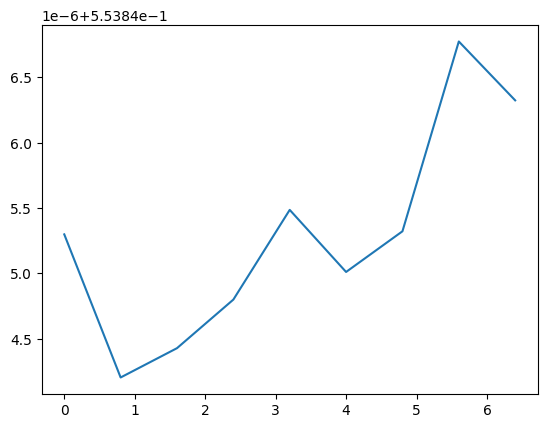

In [5]:
plt.plot(h1.mass)

For quantities from `AHFinderDirect` you have to use the `ah` namespace:

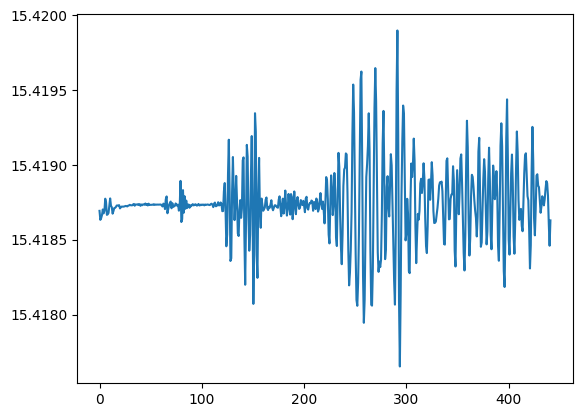

In [6]:
plt.plot(h1.ah.area)

`kuibit` can also work with shape data. `AHFinderDirect` uses multiple patches, we can plot an example in 3D. `matplotlib` is not the correct tool for 3D plotting, but it will convey the idea;

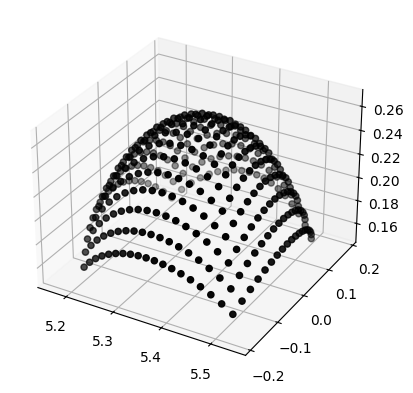

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

px, py, pz = h1.shape_at_iteration(0)

ax = plt.axes(projection='3d')
# We plot one patch
ax.scatter(px[0], py[0], pz[0], color="black", edgecolor='black')

If you plot all the patches, you will have the horizon in 3D.

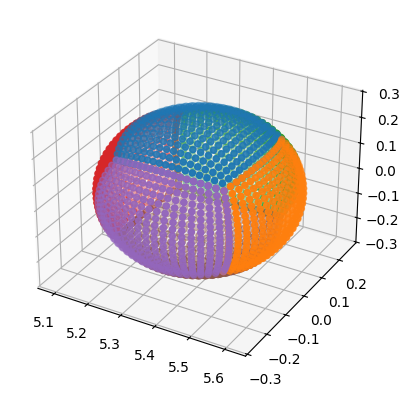

In [8]:
ax = plt.axes(projection='3d')
for ind in range(len(px)):
    ax.scatter(px[ind], py[ind], pz[ind])

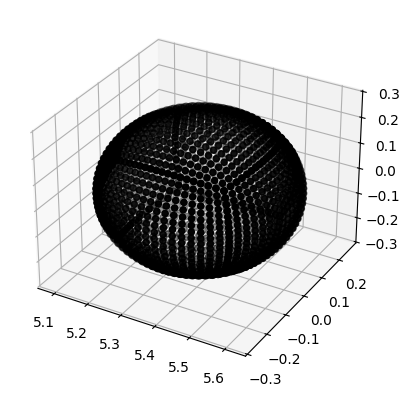

In [9]:
# Or, to make it look like a black hole
ax = plt.axes(projection='3d')
for ind in range(len(px)):
    ax.scatter(px[ind], py[ind], pz[ind], color="black")

When VTK data is available (`QuasiLocalMeasures::output_vtk_every` set to a non-zero value), it is possible to work with `QuasiLocalMeasures` quantities defined on the horizon mesh. VTK data is stored in the `vtk` attribute, which is a dictionary that maps iterations to a dictionary-like object with the various variables. The most important VTK variables are `coordinates`, which are the 3D coordinates of the mesh, and `connectivity`, which describes how the various points are connected one with others. 

`Matplotlib` does not have good methods to plot meshes, so we will look at a simple example with a cloud of points. 

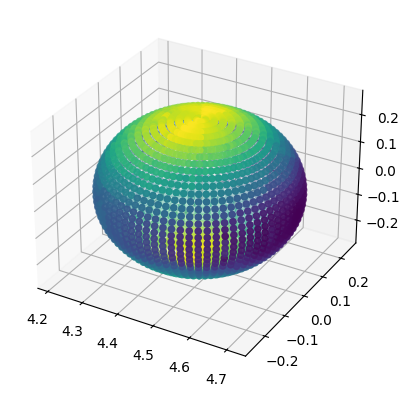

In [10]:
coordinates = h1.vtk_at_it(0).coordinates
# Let's consider one VTK variable
psi4_real = h1.vtk_at_it(0).repsi4

ax = plt.axes(projection='3d')
# coordinates is a list of (x, y, z) points, we 
# transpose it and unpack it to use it as argument
# for scatter. Then, we color it with the values of
# psi4_real
ax.scatter(*coordinates.T, c=psi4_real)

In case you want to work with a 2D slice, of the shape, you can use the method `shape_outline_at_iteration` and specify how to cut the shape. 

Note that the the distributions of points is not uniform across the horizon and `kuibit` does not do any interpolation across points. Therefore, there are values of `cut` that will lead to a malformed horizon. It is recommended to use cuts that are along the principal directions.

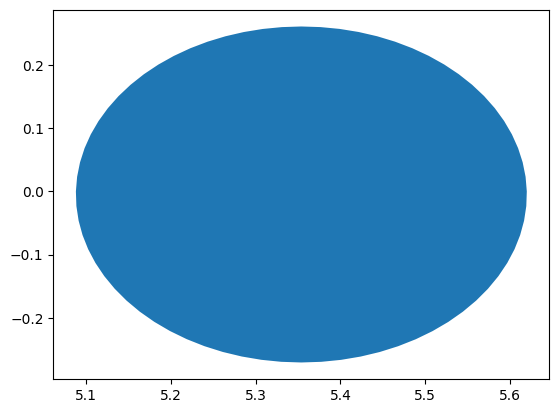

In [11]:
cut = [None, None, 0]  # Equatorial plane (z=0)

shape = h1.shape_outline_at_iteration(0, cut)

plt.fill(*shape)

You can also use the module `visualize_matplotlib` to plot the horizon in 2D. If you already have the shape, you can use `plot_horizon`.

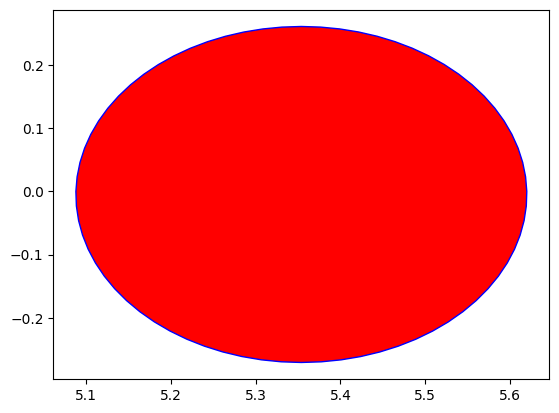

In [12]:
from kuibit import visualize_matplotlib as viz

viz.plot_horizon(shape, color='r', edgecolor='b')

Alternatively, you can use the higher level functions `plot_horizon_on_plane_at_iteration` or `plot_horizon_on_plane_at_time`. These take directly a `OneHorizon` object and the desired iteration/time.

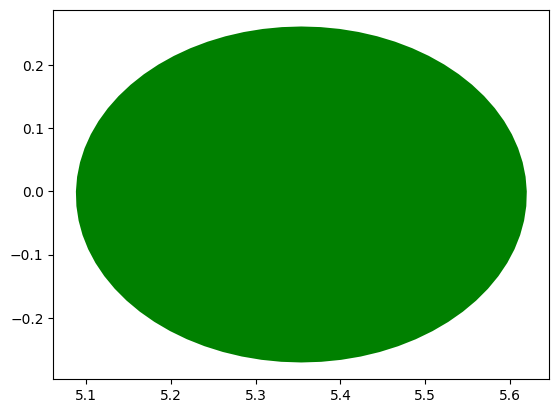

In [13]:
viz.plot_horizon_on_plane_at_time(h1, time=0, plane="xy", color='g')

There are some operations that are very common in simulations of binary black holes. For example, computing the coordinate separation between the centroids of the horizons or the angular velocity of the binary. The module `hor_utils` contains several of these functions.

To illustrate some of these functions, we manually create two `OneHorizon` objects that are nicely inspiraling. The details of how this is done are not important, so you can ignore the next cell and assume you have two horizons, one three times as massive as the other one.

In [14]:
from kuibit.cactus_horizons import OneHorizon
from kuibit.timeseries import TimeSeries

from kuibit import hor_utils

times = np.linspace(0, 100, 1000)
# We add a 0.1 to avoid having identically zero separation
cen_x = 0.1 + 10 * (times[-1] - times) * np.cos(times)
cen_y = 0.1 + 10 * (times[-1] - times) * np.sin(times)
cen_z = np.zeros_like(times)
area = np.ones_like(times)

hor1 = OneHorizon(ah_vars={
                    "centroid_x": TimeSeries(times, cen_x),
                    "centroid_y": TimeSeries(times, cen_y),
                    "centroid_z": TimeSeries(times, cen_z),
                    "area": TimeSeries(times, area),},
                    qlm_vars=None, shape_files=None, vtk_files=None)

hor2 = OneHorizon(ah_vars={
                    "centroid_x": -TimeSeries(times, cen_x),
                    "centroid_y": -TimeSeries(times, cen_y),
                    "centroid_z": TimeSeries(times, cen_z),
                    "area": 3 * TimeSeries(times, area),},
                    qlm_vars=None, shape_files=None, vtk_files=None)

First, let's plot the tracjectory. For that, we do not need any special function.

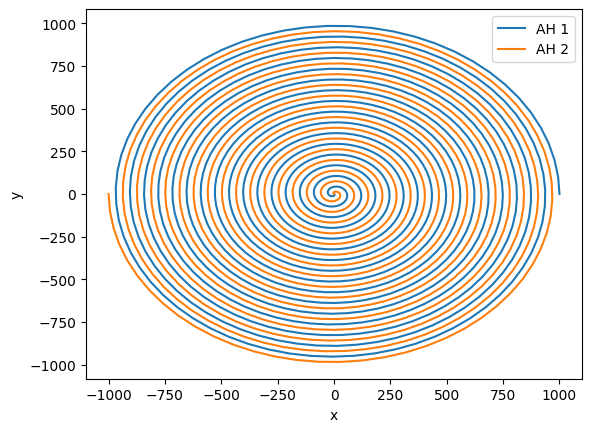

In [15]:
plt.plot(hor1.ah.centroid_x, hor1.ah.centroid_y, label="AH 1")
plt.plot(hor2.ah.centroid_x, hor2.ah.centroid_y, label="AH 2")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

This looks like a nice inspiral, but what if we moved to the frame of the center of mass? It is difficult to compute a gauge-invariant center of mass, so here we estimate it with the Netwonain formula and the irreducible mass of the horizons.

Text(0, 0.5, 'y_CM')

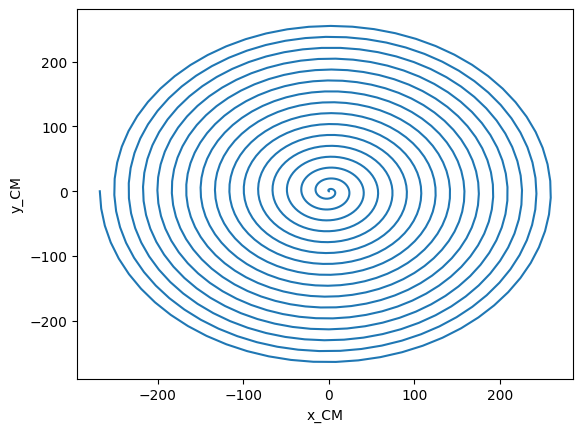

In [16]:
com = hor_utils.compute_center_of_mass(hor1, hor2)

# com is a Vector of TimeSeries
com_x, com_y = com[0], com[1]

plt.plot(com_x.y, com_y.y)
plt.xlabel("x_CM")
plt.ylabel("y_CM")

We see that the center of mass is not at the center, as usually assume. We can easily adjust our orbits by subtracting the location of the center of mass, if we want to do so.

Another common task is to compute the separation, and we can easily compute it along the three axis or its magnitude. The separation comes with a sign: we compute it as `hor1 - hor2`.

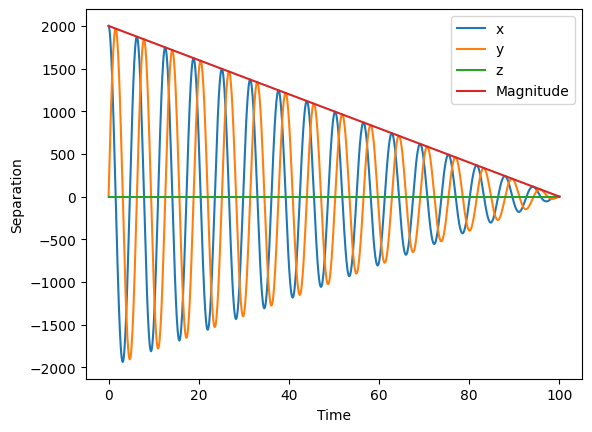

In [17]:
separation = hor_utils.compute_separation_vector(hor1, hor2)
separation_magn = hor_utils.compute_separation(hor1, hor2)

plt.plot(separation[0], label="x")
plt.plot(separation[1], label="y")
plt.plot(separation[2], label="z")
plt.plot(separation_magn, label="Magnitude")
plt.xlabel("Time")
plt.ylabel("Separation")
plt.legend()